In [1]:
#import all libraries
import pandas as pd
import numpy as np
import xarray as xr 
import rioxarray as rxr
import matplotlib.pyplot as plt
import os
#%matplotlib inline
os.chdir('D:\\study')
os.getcwd()

'D:\\study'

In [2]:
#load and read the 2015 kiambu landsat image from file location
kiambu_2005 = rxr.open_rasterio('2005\\landsat7_2005_new.tif')

#explore the metadata of the raster image
kiambu_2005


<xarray.DataArray (band: 7, y: 2067, x: 3246)> Size: 188MB
[46966374 values with dtype=float32]
Coordinates:
  * band         (band) int32 28B 1 2 3 4 5 6 7
  * x            (x) float64 26kB 36.49 36.49 36.49 36.49 ... 37.36 37.36 37.36
  * y            (y) float64 17kB -0.7585 -0.7588 -0.759 ... -1.315 -1.315
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6_VCID_2', 'B7')

In [3]:
#create a function that takes the landsat image, extract the required bands and computes the indicators, and outputs each indicator as a tiff file
def computations(image):
    def bands(image):#extract specified bands from raster and return them as separate variables
        blue, green,red,nir,swir1,swir2,thermal = image.sel(band = [1,2,3,4,5,7,6])
        return blue, green,red,nir,swir1,swir2,thermal

   #compute ModifiedDifferenceWaterIndex(mndwi) and mask threshold
    def compute_MNDWI(GREEN, SWIR1):
        mndwi = (GREEN - SWIR1) / (GREEN + SWIR1)
        return mndwi

    #mask out water bodies with threshold of 0.2
    def mask_water(image, mndwi):
        water_mask = mndwi > 0.2
        #any pixels where mndwi>0.2 are considered water and replaced with nan
        masked_image = image.where( ~water_mask, np.nan)
        return masked_image

         #function to compute NormalizedDifferenceVegetationIndex (NDVI)
    def compute_NDVI(NIR,RED):
        ndvi = (NIR-RED)/(NIR + RED)

        #normalize computed NDVI to have values between 0 and 1
        
        NDVI = (ndvi-ndvi.min())/(ndvi.max() - ndvi.min())
        return NDVI, ndvi

        #this function computes wetness using tasseled cap transformation
        
    def compute_WETNESSTM(BLUE,GREEN,RED,NIR,SWIR1,SWIR2):
        wet = ((0.2626*BLUE) + (0.2141*GREEN) + (0.0926*RED) + (0.0656*NIR) - (0.7629*SWIR1) - (0.5388*SWIR2))

        #normalize the computed wetness
        
        WET = (wet - wet.min()) / (wet.max() - wet.min())
        return WET, wet

        #this function computes Normalized Difference Built-up Index (NDBSI)
        
    def compute_NDBSI(BLUE, GREEN, RED, NIR, SWIR1):

        #compute the specral index (SI) to separate built-up from non-built up
        
        SI = ((SWIR1 + RED)-(NIR + BLUE)) / ((SWIR1 + RED) + (NIR + BLUE))
        IBI = (2 * SWIR1 / (SWIR1 + NIR) - (NIR / (NIR + RED) + GREEN / (GREEN + SWIR1))) / \
        (2 * SWIR1 / (SWIR1 + NIR) + (NIR / (NIR + RED) + GREEN / (GREEN + SWIR1)))

        #compute Index-Based Built-Up Index (IBI)to Enhance urban area detection
        
        ndbsi = (SI + IBI)/2
        NDBSI = (ndbsi - ndbsi.min()) / (ndbsi.max() - ndbsi.min())
        return NDBSI, ndbsi

        #compute the Lnad Surface Temperature (LST)
        
    def compute_LST(TIR):
        lst = TIR - 273.15
        LST = (lst - lst.min()) / (lst.max() - lst.min())
        return LST, lst
    
        #COMPUTE INDIES
    #extract the bands first
    blue, green, red, nir, swir1, swir2, thermal = bands(image)
    mndwi = compute_MNDWI(green, swir1)
    masked_image = mask_water(image,mndwi)
    #extract bands again from masked image
    blue, green, red, nir, swir1, swir2, thermal = bands(masked_image)
    NDVI, ndvi = compute_NDVI(nir, red)
    WET, wet = compute_WETNESSTM(blue, green, red, nir, swir1, swir2)
    NDBSI, ndbsi = compute_NDBSI(blue, green, red, nir, swir1)
    LST, lst = compute_LST(thermal)
   # MNDWI = compute_MNDWI(green, swir1)
    return NDVI, WET, NDBSI, LST, mndwi, ndvi, wet, lst, ndbsi

NDVI, WET, NDBSI, LST, mndwi, ndvi, wet, lst, ndbsi = computations(kiambu_2005)

In [4]:
#check the shapes of the rasters
NDVI.shape, WET.shape, NDBSI.shape, LST.shape, ndvi.shape

((2067, 3246), (2067, 3246), (2067, 3246), (2067, 3246), (2067, 3246))

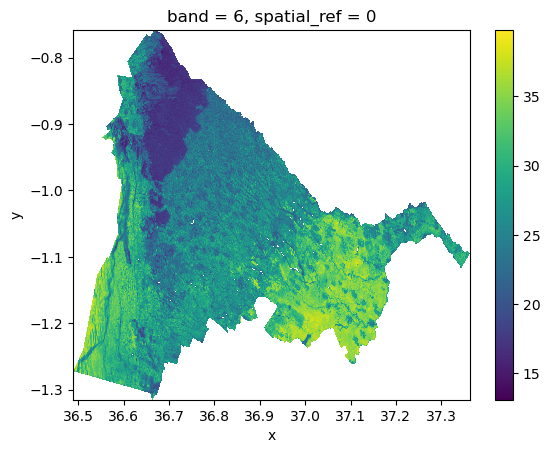

In [5]:
#plot lst

lst.plot.imshow()

In [6]:
#compute RSEI using Principal Component Analysis (PCA)

#pca preprocessing

#This function combines the four 2D rasters into a single 3D array and then reshapes it to 2D array suitable for PCA.

#this rseults into a 3D array where the first two dimensions represents rows and columns, and third represents the bands(NDVI,NDBSI,WET,LST)

def stacking(im1, im2, im3, im4):

    #axis=-1 ensures the last dimension is the band dimension
    
    stacked = np.stack([im1, im2, im3, im4], axis = -1)

    #compute the total number of pixels by multiplying rows by columns

    n_samples = stacked.shape[0] * stacked.shape[1]

    #reshape the stacked from 3D array to 2D array of total pixels(n_samples) and four bands
    
    stacked_flat = stacked.reshape((n_samples, stacked.shape[2]))
    
    print(f'Shape of stacked flat:', stacked_flat.shape)

    #return the original stacked rasters, total pixels, and reshaped 2D array raster respectively
    return stacked, n_samples, stacked_flat

#apply to image
stacked, n_samples, stacked_flat = stacking(NDVI, WET, NDBSI, LST)

Shape of stacked flat: (6709482, 4)


In [7]:
#import the PCA module from sklearn.decomposistion library

from sklearn.decomposition import PCA

In [8]:
#pca processing

#this function takes 3 images: the reshaped 2D array containing indicators, the original 3D stacked array and kiambu-2005 tiff to extract metadata
def pca_processing(im1, im2, im3):
    #create mask to remove nan values

    #this is boolean to identify pixels without NaN values
    
    valid_mask = ~np.isnan(im1).any(axis = 1)

    #this contains all pixels without NaN values
    
    stacked_flat_valid = im1[valid_mask]

    #initialize PCA with 3 principal components
    
    pca = PCA(n_components = 3)

    #compute PCA for the valid pixels
    
    pca_results = pca.fit_transform(stacked_flat_valid)

    #reconstruct the PCA rseult to match the original number of pixels
    
    pca_result = np.full((im1.shape[0], 3), np.nan)
    
    pca_result[valid_mask] = pca_results
    
    print(f'shape of pca result is:', pca_result.shape)
    
    pca_bands = pca_result.reshape(im2.shape[0], im2.shape[1], 3)
    
    print(f'The shape of pca bands is:', pca_bands.shape)

    #the PCA results are transposed to match the expected number of dimensions
    
    pca_bands_T = np.transpose(pca_bands, (2,0,1))
    
    #change to data array
    
    pca_da = xr.DataArray(pca_bands_T,
                          dims = ('band', 'y', 'x'),
                          coords = {'band':np.arange(1, pca_bands_T.shape[0] + 1), 'y':im3.y, 'x':im3.x},
                          attrs = { k:v for k, v in im3.attrs.items() if k!='long_name'})
    #define crs
    
    pca_da_prj = pca_da.rio.write_crs('EPSG:4326')
    
    print(f'New pca cr is;', pca_da_prj.rio.crs)
    
    return pca_da_prj

#apply to image
pca_da_prj = pca_processing(stacked_flat, stacked, kiambu_2005)

shape of pca result is: (6709482, 3)
The shape of pca bands is: (2067, 3246, 3)
New pca cr is; EPSG:4326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6879310607910156..1.0].


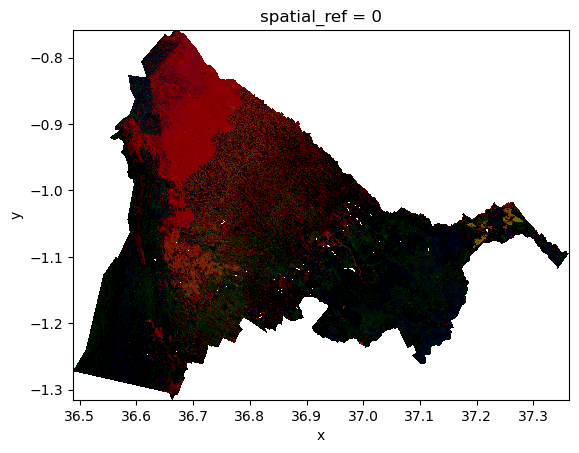

In [9]:
#plot to show
pca_da_prj.plot.imshow()

In [18]:
#normalize the dataset

def rsei_comp(image):
    rsei = (pca_da_prj.max() - pca_da_prj) / (pca_da_prj.max() - pca_da_prj.min())
    RSEI = (1 - rsei)
    return RSEI

#apply to image

RSEI = rsei_comp(pca_da_prj)


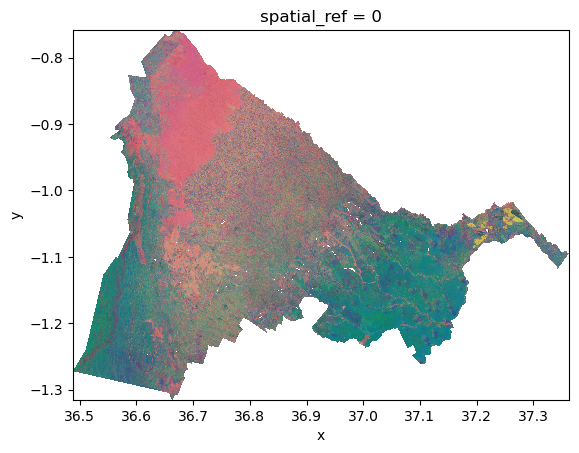

In [21]:
#visualize the rsei
RSEI.plot.imshow()
RSEI.rio.to_raster('Results\\RSEI\\rsei205.tif')

In [36]:
#save all the images
def save_data(ndvi, ndbsi, wet, lst, mndwi, RSEI): #mndwi, rsei):
    #dictionary to store data for each index
    data_dict = {
        'ndvi':ndvi,
        'ndbsi':ndbsi,
        'wet':wet,
        'lst':lst,
        'mndwi':mndwi,
        'RSEI':RSEI
    } 
    #dictionary to store file paths
    file_paths = {
        'ndvi':'Results\\NDVI\\NDVI_2005.tif',
        'ndbsi':'Results\\NDBSI\\NDBSI_2005.tif',
        'wet':'Results\\WETNESS\\WET_2005.tif',
        'lst':'Results\\LST\\LST_2005.tif',
        'mndwi':'Results\\MNDWI\\MNDWI_2005.tif',
        'RSEI':'Results\\RSEI\\RSEI_2005.tif'
    }
    #loop through each index and save corresponding data
    for key, path in file_paths.items():
        data_dict[key].rio.to_raster(path)

    print('All images saved successfully!')

#apply 
save_data(wet,lst,RSEI)

All images saved successfully!
